In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier
import pickle
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import re
pd.options.display.max_rows = 100
pd.options.display.max_columns = 125

### Creating the data set

In [4]:
os.listdir('ACCIDENT')

['ACCIDENT_CHAINAGE.csv',
 'ACCIDENT_LOCATION.csv',
 'VEHICLE.csv',
 'NODE_ID_COMPLEX_INT_ID.csv',
 'NODE.csv',
 'ACCIDENT.csv',
 'ACCIDENT_EVENT.csv',
 'SUBDCA.csv',
 'PERSON.csv',
 'ROAD_SURFACE_COND.csv',
 'Statistic Checks.csv',
 'ATMOSPHERIC_COND.csv']

In [5]:
files = os.listdir('ACCIDENT')
files = files[0:10] + files[11:]  # Everything but the control data

In [6]:
d = dict()
for file in files:
    print(file)
    d[file.replace('.csv', '')] = pd.read_csv('ACCIDENT/' + file)
for i in d:
    if 'NODE_ID' in d[i].columns and i != 'ACCIDENT':
        d[i].pop('NODE_ID')
    elif 'VEHICLE_ID' in d[i].columns and i != 'VEHICLE':
        d[i].pop('VEHICLE_ID')
    elif 'PERSON_ID' in d[i].columns and i != 'PERSON':
        d[i].pop('PERSON_ID')
# The warnings of relevant columns (regarding dtype) will be coped with in the transformation stage

ACCIDENT_CHAINAGE.csv
ACCIDENT_LOCATION.csv
VEHICLE.csv


/var/folders/78/lv70vftj3nl2dv5mkdv90wlm0000gn/T/ipykernel_63152/3970359683.py:4: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  d[file.replace('.csv', '')] = pd.read_csv('ACCIDENT/' + file)


NODE_ID_COMPLEX_INT_ID.csv
NODE.csv
ACCIDENT.csv


/var/folders/78/lv70vftj3nl2dv5mkdv90wlm0000gn/T/ipykernel_63152/3970359683.py:4: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  d[file.replace('.csv', '')] = pd.read_csv('ACCIDENT/' + file)


ACCIDENT_EVENT.csv
SUBDCA.csv
PERSON.csv


/var/folders/78/lv70vftj3nl2dv5mkdv90wlm0000gn/T/ipykernel_63152/3970359683.py:4: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  d[file.replace('.csv', '')] = pd.read_csv('ACCIDENT/' + file)


ROAD_SURFACE_COND.csv
ATMOSPHERIC_COND.csv


In [8]:
# Processing accident chainage df to allow merging
d['ACCIDENT_CHAINAGE'].rename(columns={'Node Id': 'NODE_ID'}, inplace=True)
d['ACCIDENT_CHAINAGE'].dropna(how='all', inplace=True)  # Drop row with only NAs while we're at it
d['ACCIDENT_CHAINAGE']['NODE_ID'].replace({',': ''}, regex=True, inplace=True)
d['ACCIDENT_CHAINAGE'] = d['ACCIDENT_CHAINAGE'].astype({'NODE_ID': 'int64'})

In [ ]:
# d['NODE'][d['NODE']['ACCIDENT_NO'] == 'T20140000522']
# We can see that one accident can count to several DEG_URBAN_NAME and several POSTCODE_NO. We will not change that

In [9]:
# Merging the dataframes into one
m = pd.merge(d['ACCIDENT'], d['ACCIDENT_LOCATION'], on='ACCIDENT_NO')
m = pd.merge(m, d['VEHICLE'], on='ACCIDENT_NO')
m = pd.merge(m, d['NODE'], on='ACCIDENT_NO')
m = pd.merge(m, d['ATMOSPHERIC_COND'], on='ACCIDENT_NO')
m = pd.merge(m, d['ACCIDENT_CHAINAGE'], on='NODE_ID')
m = pd.merge(m, d['PERSON'], on='ACCIDENT_NO')
m = pd.merge(m, d['ROAD_SURFACE_COND'], on='ACCIDENT_NO')
m = pd.merge(m, d['SUBDCA'], on='ACCIDENT_NO')
m = pd.merge(m, d['ACCIDENT_EVENT'], on='ACCIDENT_NO')
m = pd.merge(m, d['NODE_ID_COMPLEX_INT_ID'], on='ACCIDENT_NO')

### Looking at (possibly) relevant features and transformations thereof

In [10]:
m = m[sorted(m.columns)]

In [11]:
'''
Variabes to predict:
SEVERITY
NO_PERSONS_KILLED and NO_PERSONS_INJ_2 vs NO_PERSONS_INJ_3 and NO_PERSONS_NOT_INJ
'''

'\nVariabes to predict:\nSEVERITY\nNO_PERSONS_KILLED and NO_PERSONS_INJ_2 vs NO_PERSONS_INJ_3 and NO_PERSONS_NOT_INJ\n'

In [12]:
'''
Vehicle information:
CARRY_CAPACITY
CONSTRUCTION_TYPE
CUBIC_CAPACITY
FUEL_TYPE
NO_OF_CYLINDERS
NO_OF_WHEELS
SEATING_CAPACITY
TARE_WEIGHT
TOTAL_NO_OCCUPANTS
VEHICLE_BODY_STYLE
VEHICLE_COLOUR_1
VEHICLE_COLOUR_2
VEHICLE_MAKE
VEHICLE_TYPE

'''

'\nVehicle information:\nCARRY_CAPACITY\nCONSTRUCTION_TYPE\nCUBIC_CAPACITY\nFUEL_TYPE\nNO_OF_CYLINDERS\nNO_OF_WHEELS\nSEATING_CAPACITY\nTARE_WEIGHT\nTOTAL_NO_OCCUPANTS\nVEHICLE_BODY_STYLE\nVEHICLE_COLOUR_1\nVEHICLE_COLOUR_2\nVEHICLE_MAKE\nVEHICLE_TYPE\n\n'

In [13]:
'''
Personal information:
AGE
Age Group
SEX
'''

'\nPersonal information:\nAGE\nAge Group\nSEX\n'

In [14]:
'''
Situation information:
ACCIDENTDATE
ACCIDENTTIME
ACCIDENT_TYPE
ATMOSPH_COND
CAUGHT_FIRE
DAY_OF_WEEK
DCA_CODE
EJECTED_CODE
EVENT_TYPE
HELMET_BELT_WORN
INITIAL_IMPACT
LAMPS
LEVEL_OF_DAMAGE
LIGHT_CONDITION
NO_OF_VEHICLES
NO_PERSONS
NO_PERSONS_INJ_2
NO_PERSONS_INJ_3
NO_PERSONS_KILLED
NO_PERSONS_NOT_INJ
OBJECT_TYPE
PEDEST_MOVEMENT
POLICE_ATTEND
ROAD_GEOMETRY
ROAD_SURFACE_TYPE only three categories
ROAD_USER_TYPE
SEATING_POSITION
SEVERITY
SPEED_ZONE
SUB_DCA_CODE, SUB_DCA_SEQ
SURFACE_COND 5 different surface conditions
TAKEN_HOSPITAL
TRAFFIC_CONTROL
VEHICLE_1_COLL_PT
VEHICLE_DCA_CODE
VEHICLE_MOVEMENT

'''

'\nSituation information:\nACCIDENTDATE\nACCIDENTTIME\nACCIDENT_TYPE\nATMOSPH_COND\nCAUGHT_FIRE\nDAY_OF_WEEK\nDCA_CODE\nEJECTED_CODE\nEVENT_TYPE\nHELMET_BELT_WORN\nINITIAL_IMPACT\nLAMPS\nLEVEL_OF_DAMAGE\nLIGHT_CONDITION\nNO_OF_VEHICLES\nNO_PERSONS\nNO_PERSONS_INJ_2\nNO_PERSONS_INJ_3\nNO_PERSONS_KILLED\nNO_PERSONS_NOT_INJ\nOBJECT_TYPE\nPEDEST_MOVEMENT\nPOLICE_ATTEND\nROAD_GEOMETRY\nROAD_SURFACE_TYPE only three categories\nROAD_USER_TYPE\nSEATING_POSITION\nSEVERITY\nSPEED_ZONE\nSUB_DCA_CODE, SUB_DCA_SEQ\nSURFACE_COND 5 different surface conditions\nTAKEN_HOSPITAL\nTRAFFIC_CONTROL\nVEHICLE_1_COLL_PT\nVEHICLE_DCA_CODE\nVEHICLE_MOVEMENT\n\n'

In [15]:
'''
Location information:
COMPLEX_INT_NO
Chainage
DEG_URBAN_NAME
DIRECTION_LOCATION
DISTANCE_LOCATION
LGA_NAME
LGA_NAME_ALL
LICENCE_STATE
Lat
Long
NODE_TYPE
OWNER_POSTCODE
POSTCODE
POSTCODE_NO
REGION_NAME
REG_STATE
ROAD_NAME, ROAD_NAME_INT
ROAD_ROUTE_1
ROAD_TYPE

'''

'\nLocation information:\nCOMPLEX_INT_NO\nChainage\nDEG_URBAN_NAME\nDIRECTION_LOCATION\nDISTANCE_LOCATION\nLGA_NAME\nLGA_NAME_ALL\nLICENCE_STATE\nLat\nLong\nNODE_TYPE\nOWNER_POSTCODE\nPOSTCODE\nPOSTCODE_NO\nREGION_NAME\nREG_STATE\nROAD_NAME, ROAD_NAME_INT\nROAD_ROUTE_1\nROAD_TYPE\n\n'

In [16]:
'''
Transformations:
ACCIDENTDATE to date format and extract year, month, day, weekday, spline for month, weekday / maybe try onehot for weekday later
ACCIDENTTIME to time format and extract hour, minute only, spline for hour
ACCIDENT_TYPE to one-hot
AGE data cleaning: handling NA
ATMOSPH_COND to one-hot
'Age Group' to one-hot
CARRY_CAPACITY data quality is questionable, 80% is NA, possibly sqrt transformation
CAUGHT_FIRE reencode to -1, 0, 1, unknowns to 0
COMPLEX_INT_NO convert to binary
DAY_OF_WEEK remove columns with 0 values and one-hot
DCA_CODE one-hot
DEG_URBAN_NAME one-hot
EJECTED_CODE binary ejected or not
EVENT_TYPE remove rows with 9 or 0, one-hot
FUEL_TYPE one-hot
HELMET_BELT_WORN -1, 0, 1: not worn, unknown, worn
INITIAL_IMPACT one-hot
LAMPS turn into binary, possible remove not applicable and unknown, otherwise fuse them to one
LEVEL_OF_DAMAGE change 9 to 0 or remove all records where it is not known
LICENCE_STATE fuse Z and space, possibly remove them, one-hot
LIGHT_CONDITION one-hot
NODE_TYPE remove the unknowns and one-hot
NO_OF_WHEELS binary: bike 2 and fewer vs. non-bike 3+
NO_PERSONS 1-10 each gets their own and everything above is one, ordinal
OBJECT_TYPE remove the unknown ones, binary
PEDEST_MOVEMENT binary encoding: was a factor or not
REGION_NAME remove the space ones, one-hot
ROAD_ROUTE_1 group into different road types and one-hot
ROAD_SURFACE_TYPE remove 9, one-hot
ROAD_USER_TYPE clean: str to int, one-hot
SEATING_POSITION one-hot
SPEED_ZONE clean up, same steps between intervals and one-hot since there does not seem to be a trend
SURFACE_COND possibly remove 9 and one hot
TARE_WEIGHT data cleaning
TRAFFIC_CONTROL data cleaning and one-hot
TRAILER_TYPE binary: H (no trailer) and not H (trailer)
VEHICLE_1_COLL_PT one-hot
VEHICLE_2_COLL_PT one-hot
VEHICLE_MOVEMENT clean
VEHICLE_TYPE
VEHICLE_YEAR_MANUF subtract from current year

'''

"\nTransformations:\nACCIDENTDATE to date format and extract year, month, day, weekday, spline for month, weekday / maybe try onehot for weekday later\nACCIDENTTIME to time format and extract hour, minute only, spline for hour\nACCIDENT_TYPE to one-hot\nAGE data cleaning: handling NA\nATMOSPH_COND to one-hot\n'Age Group' to one-hot\nCARRY_CAPACITY data quality is questionable, 80% is NA, possibly sqrt transformation\nCAUGHT_FIRE reencode to -1, 0, 1, unknowns to 0\nCOMPLEX_INT_NO convert to binary\nDAY_OF_WEEK remove columns with 0 values and one-hot\nDCA_CODE one-hot\nDEG_URBAN_NAME one-hot\nEJECTED_CODE binary ejected or not\nEVENT_TYPE remove rows with 9 or 0, one-hot\nFUEL_TYPE one-hot\nHELMET_BELT_WORN -1, 0, 1: not worn, unknown, worn\nINITIAL_IMPACT one-hot\nLAMPS turn into binary, possible remove not applicable and unknown, otherwise fuse them to one\nLEVEL_OF_DAMAGE change 9 to 0 or remove all records where it is not known\nLICENCE_STATE fuse Z and space, possibly remove them,

In [17]:
columns_to_pop = ['ATMOSPH_COND_SEQ', 'Accident Type Desc', 'Atmosph Cond Desc', 'CONSTRUCTION_TYPE', 
                  'CUBIC_CAPACITY', 'Chainage',
                  'Chainage Seq', 'DCA Description', 'DIRECTION_LOCATION', 'DIRECTORY', 'DISTANCE_LOCATION', 'DRIVER_INTENT',
                  'Day Week Description', 'EDITION', 'EVENT_SEQ_NO', 'Event Type Desc', 'FINAL_DIRECTION', 
                  'GRID_REFERENCE_X', 'GRID_REFERENCE_Y', 'INITIAL_DIRECTION', 'INJ_LEVEL', 'Inj Level Desc', 'LGA_NAME', 
                  'LGA_NAME_ALL', 'Light Condition Desc', 'NEAREST_KM_POST', 'NODE_ID', 'NO_OF_CYLINDERS',
                  'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ',
                  'OFF_ROAD_LOCATION', 'OWNER_POSTCODE',
                  'Object Type Desc', 'PAGE', 'PERSON_ID', 'POLICE_ATTEND', 'POSTCODE', 'POSTCODE_NO', 'REG_STATE', 
                  'ROAD_GEOMETRY', 'ROAD_NAME', 'ROAD_NAME_INT', 'ROAD_TYPE', 'ROAD_TYPE_INT', 'Road Geometry Desc',
                  'Road Surface Type Desc', 'Road User Type Desc', 'Route No', 'SEATING_CAPACITY', 'SEX',
                  'SUB_DCA_CODE', 'SUB_DCA_SEQ', 'SURFACE_COND_SEQ', 'Sub Dca Code Desc', 'Surface Cond Desc',
                  'TAKEN_HOSPITAL', 'TOTAL_NO_OCCUPANTS', 'TOWED_AWAY_FLAG', 'Traffic Control Desc', 'VEHICLE_1_ID', 
                  'VEHICLE_2_ID', 'VEHICLE_BODY_STYLE', 'VEHICLE_COLOUR_1', 'VEHICLE_COLOUR_2', 'VEHICLE_DCA_CODE', 
                  'VEHICLE_ID', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_POWER', 'VEHICLE_WEIGHT', 'VICGRID94_X', 'VICGRID94_Y', 
                  'Vehicle 1 Coll Pt Desc', 'Vehicle 2 Coll Pt Desc', 'Vehicle Type Desc']

In [300]:
df = m.drop(columns_to_pop, axis=1)
d_plot = df.copy()

### Applying necessary transformations

In [301]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [302]:
%%capture
# ACCIDENTDATE
df['ACCIDENTDATE'] = pd.to_datetime(df['ACCIDENTDATE'], infer_datetime_format=True)
df['YEAR'] = pd.DatetimeIndex(df['ACCIDENTDATE']).year
df['MONTH'] = pd.DatetimeIndex(df['ACCIDENTDATE']).month
df['DAY'] = pd.DatetimeIndex(df['ACCIDENTDATE']).day
df['WEEK_DAY'] = pd.DatetimeIndex(df['ACCIDENTDATE']).weekday + 1
# Spline transformations
m_spline = periodic_spline_transformer(12, n_splines=6).fit_transform(pd.DataFrame(df['MONTH']))
m_spline_df = pd.DataFrame(m_spline, columns=[f"month_spline_{i}" for i in range(m_spline.shape[1])])
w_spline = periodic_spline_transformer(7, n_splines=3).fit_transform(pd.DataFrame(df['WEEK_DAY']))
w_spline_df = pd.DataFrame(w_spline, columns=[f"week_spline_{i}" for i in range(w_spline.shape[1])])
df = df.join(m_spline_df)
df = df.join(w_spline_df)
# df = df.join(pd.get_dummies(df['WEEK_DAY'], prefix='Weekday'))  # If we wanted to do one-hot for week-day instead
df.drop(['MONTH', 'WEEK_DAY'], axis=1, inplace=True)
df.pop('ACCIDENTDATE')

In [303]:
%%capture
# ACCIDENTTIME
df['ACCIDENTTIME'] = df['ACCIDENTTIME'].apply(lambda x: x.strip())
df['ACCIDENTTIME'] = pd.to_datetime(df['ACCIDENTTIME'], format='%H:%M:%S')
df['HOUR'] = pd.DatetimeIndex(df['ACCIDENTTIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['ACCIDENTTIME']).minute
# Spline transformation
h_spline = periodic_spline_transformer(24, n_splines=12).fit_transform(pd.DataFrame(df['HOUR']))
h_spline_df = pd.DataFrame(h_spline, columns=[f"hour_spline_{i}" for i in range(h_spline.shape[1])])
df = df.join(h_spline_df)
df.pop('HOUR')
df.pop('ACCIDENTTIME')

In [304]:
%%capture
# ACCIDENT_TYPE
df = df.join(pd.get_dummies(df['ACCIDENT_TYPE'], prefix='A_TYPE'))
df.pop('ACCIDENT_TYPE')

In [305]:
# AGE
df.dropna(subset='AGE', inplace=True)
df['AGE'] = df['AGE'].astype('int32')

In [306]:
%%capture
# ATMOSPH_COND
df = df.join(pd.get_dummies(df['ATMOSPH_COND'], prefix='AT_COND'))
df.pop('ATMOSPH_COND')

In [307]:
%%capture
# 'Age Group'
df = df.join(pd.get_dummies(df['Age Group'], prefix='AGE_G'))
df.pop('Age Group')

In [308]:
# CARRY_CAPACITY
df['CARRY_CAPACITY'] = df['CARRY_CAPACITY'].fillna(round(df['CARRY_CAPACITY'].mean(), 1))

In [309]:
# CAUGHT_FIRE
def c_checks(x):
    if x == 2:
        return -1
    elif x == 1:
        return 1
    else:
        return 0
df['CAUGHT_FIRE'] = df['CAUGHT_FIRE'].apply(c_checks)

In [310]:
# COMPLEX_INT_NO
df['COMPLEX_INT_NO'] = df['COMPLEX_INT_NO'].fillna(0).astype('Int32').apply(lambda x: x%1 + 1 if x > 0 else x)

In [314]:
%%capture
# DCA_CODE
df = df.join(pd.get_dummies(df['DCA_CODE'], prefix='DCA'))
df.pop('DCA_CODE')

In [315]:
%%capture
# DEG_URBAN_NAME
df = df.join(pd.get_dummies(df['DEG_URBAN_NAME'], prefix='URBAN_NAME'))
df.pop('DEG_URBAN_NAME')

In [316]:
# EJECTED_CODE
def e_checks(x):
    if x != '1' and x != '2':
        return 0
    else:
        return 1
df['EJECTED_CODE'] = df['EJECTED_CODE'].apply(e_checks)

In [317]:
%%capture
# EVENT_TYPE
df = df[df['EVENT_TYPE'] != '0']
df = df.join(pd.get_dummies(df['EVENT_TYPE'], prefix='EVENT'))
df.pop('EVENT_TYPE')

In [318]:
%%capture
# FUEL_TYPE
df = df.join(pd.get_dummies(df['FUEL_TYPE'].apply(lambda x: x.replace(' ', 'Z') if x == ' ' else x), prefix='FUEL'))
df.pop('FUEL_TYPE')

In [319]:
# HELMET_BELT_WORN
def h_check(x):
    x = int(x)
    if x in [1, 3, 6]:
        return 1
    elif x in [2, 4, 5, 7]:
        return -1
    else:
        return 0
        
df['HELMET_BELT_WORN'] = df['HELMET_BELT_WORN'].apply(h_check)

In [320]:
%%capture
# INITIAL_IMPACT
df = df.join(pd.get_dummies(df['INITIAL_IMPACT'].apply(lambda x: x.replace(' ', '9') if x == ' ' else x),
                            prefix='Impact'))
df.pop('INITIAL_IMPACT')

In [321]:
# LAMPS
def l_check(x):
    x = int(x)
    if x == 2:
        return -1
    elif x in [0, 9]:
        return 0
    else:
        return 1
df['LAMPS'] = df['LAMPS'].apply(l_check)

In [322]:
# LEVEL_OF_DAMAGE
def d_check(x):
    if x in [6, 9]:
        return 0
    else:
        return x
df['LEVEL_OF_DAMAGE'] = df['LEVEL_OF_DAMAGE'].apply(d_check)

In [323]:
%%capture
# LICENCE_STATE
def ls_check(x):
    if x == ' ':
        return 0
    else:
        return x
df = df.join(pd.get_dummies(df['LICENCE_STATE'].apply(lambda x: x.replace(' ', 'Z') if x == ' ' else x),
                            prefix='LICENCE'))
df.pop('LICENCE_STATE')

In [324]:
%%capture
# LIGHT_CONDITION
def lc_check(x):
    if x == 9:
        return 6
    else:
        return x
df = df.join(pd.get_dummies(df['LIGHT_CONDITION'].apply(lc_check), prefix='LIGHT'))
df.pop('LIGHT_CONDITION')

In [325]:
%%capture
# NODE_TYPE
df = df[df['NODE_TYPE'] != ' ']
df = df.join(pd.get_dummies(df['NODE_TYPE'], prefix='NODE'))
df.pop('NODE_TYPE')

In [326]:
%%capture
# NO_OF_WHEELS
def wh_check(x):
    if pd.isna(x):
        return 1  # Making the assumption that all unknowns are not bikes -> be on the lookout in the analysis
    elif x > 3:
        return 1
    else:
        return 0
df = df.join(pd.get_dummies(df['NO_OF_WHEELS'].apply(wh_check), prefix='WHEELS'))
df.pop('NO_OF_WHEELS')

In [327]:
# NO_PERSONS
def np_check(x):
    if x > 9:
        return 10
    else:
        return x
df['NO_PERSONS'] = df['NO_PERSONS'].apply(np_check)

In [328]:
# OBJECT_TYPE
def ot_check(x):
    x = int(x)
    if x == 99 or x == 11 :
        return 0
    else:
        return 1
df = df[~pd.isna(df['OBJECT_TYPE'])]
df['OBJECT_TYPE'] = df['OBJECT_TYPE'].apply(ot_check)

In [329]:
# PEDEST_MOVEMENT
def pm_check(x):
    x = int(x)
    if x == 9 or x == 0:
        return 0
    else:
        return 1
df = df[df['PEDEST_MOVEMENT'] != ' ']
df['PEDEST_MOVEMENT'] = df['PEDEST_MOVEMENT'].apply(pm_check)

In [330]:
%%capture
# REGION_NAME
df = df[df['REGION_NAME'] != ' ']
df = df.join(pd.get_dummies(df['REGION_NAME']))
df.pop('REGION_NAME')

In [331]:
%%capture
# ROAD_ROUTE_1
def rr_check(x):
    return int(x // 1000)
df = df[df['ROAD_ROUTE_1'] != -1]
df = df.join(pd.get_dummies(df['ROAD_ROUTE_1'].apply(rr_check), prefix='ROAD_ROUTE'))
df.pop('ROAD_ROUTE_1')

In [332]:
%%capture
# ROAD_SURFACE_TYPE
df = df.join(pd.get_dummies(df['ROAD_SURFACE_TYPE'], prefix='SURFACE'))
df.pop('ROAD_SURFACE_TYPE')

In [333]:
%%capture
# ROAD_USER_TYPE
df = df[df['ROAD_USER_TYPE'] != ' ']
df = df.join(pd.get_dummies(df['ROAD_USER_TYPE'].apply(int), prefix='USER'))
df.pop('ROAD_USER_TYPE')

In [334]:
%%capture
# SEATING_POSITION
def sp_check(x):
    if pd.isna(x):
        return 'D'  # We make the assumption that all unknowns are drivers -> careful in the futher analysis
    else:
        return x.strip()
df = df[df['SEATING_POSITION'] != ' ']
df = df.join(pd.get_dummies(df['SEATING_POSITION'].apply(sp_check), prefix='SEATING'))
df.pop('SEATING_POSITION')

In [335]:
%%capture
# SPEED_ZONE
df = df.join(pd.get_dummies(df['SPEED_ZONE'], prefix='SPEED'))
df.pop('SPEED_ZONE')

In [336]:
# SURFACE_COND
df['SURFACE_COND'] = df['SURFACE_COND'].apply(lambda x: 1 if x == 9 else x)

In [337]:
# TARE_WEIGHT
df['TARE_WEIGHT'] = df['TARE_WEIGHT'].fillna(round(df['TARE_WEIGHT'].mean(), 1))

In [338]:
%%capture
# TRAFFIC_CONTROL
def tc_check(x):
    x = int(x)
    if x == 15:
        return 99  # Since unknown and other have the same information value, we merge them into one
    else:
        return x
df = df[df['TRAFFIC_CONTROL'] != '  ']
df = df.join(pd.get_dummies(df['TRAFFIC_CONTROL'].apply(tc_check), prefix='T_CONTROL'))
df.pop('TRAFFIC_CONTROL')

In [339]:
# TRAILER_TYPE
def tt_check(x):
    if x == 'H':
        return 0
    else:
        return 1
df = df[df['TRAILER_TYPE'] != ' ']
df['TRAILER_TYPE'] = df['TRAILER_TYPE'].apply(tt_check)

In [340]:
%%capture
# VEHICLE_1_COLL_PT
df = df[~pd.isna(df['VEHICLE_1_COLL_PT'])]
df = df.join(pd.get_dummies(df['VEHICLE_1_COLL_PT'], prefix='VEHICLE_1_COLL'))
df.pop('VEHICLE_1_COLL_PT')

In [341]:
%%capture
# VEHICLE_2_COLL_PT
df = df[~pd.isna(df['VEHICLE_2_COLL_PT'])]
df = df.join(pd.get_dummies(df['VEHICLE_2_COLL_PT'], prefix='VEHICLE_2_COLL'))
df.pop('VEHICLE_2_COLL_PT')

In [342]:
%%capture
# VEHICLE_MOVEMENT
df = df[df['VEHICLE_MOVEMENT'] != '  ']
df = df.join(pd.get_dummies(df['VEHICLE_MOVEMENT'].apply(int), prefix='VEHICLE_MOVEMENT'))
df.pop('VEHICLE_MOVEMENT')

In [343]:
%%capture
# VEHICLE_TYPE
df = df.join(pd.get_dummies(df['VEHICLE_TYPE'].apply(lambda x: 99 if x == 18 else x), prefix='V_TYPE'))
df.pop('VEHICLE_TYPE')

In [344]:
# VEHICLE_YEAR_MANUF
diff = pd.to_datetime("today").year - df['VEHICLE_YEAR_MANUF']
df['VEHICLE_YEAR_MANUF'] = diff.fillna(diff.mean())

### Predicting fatalities using tree models

In [345]:
target1 = df['SEVERITY'].apply(lambda x: 0 if x != 1 else 1)  # Differentiating only between fatal and non-fatal accidents
target2 = df['SEVERITY'].apply(lambda x: 0 if x not in [1, 2] else 1)  # Fatal & severe vs not severe
reg_target = df['SEVERITY']  # Level of severity
df.drop(['SEVERITY'], axis=1, inplace=True)

In [346]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], target1)  # since we don't want the ACCIDENT_NO

In [ ]:
import time
HGBC = HistGradientBoostingClassifier()

print('Hist starting')
t = time.time()
HGBC_model = HGBC.fit(X_train, y_train)
print(time.time() - t)

In [75]:
accuracy_score(HGBC_model.predict(X_test), y_test)

0.9875052973920165

In [129]:
# pickle.dump(HGBC_model, open('HGBC_model.sav', 'wb'))  # to save the model once it has been fitted
# HGBC_model = pickle.load(open('HGBC_model.sav', 'rb'))  # to load model again

In [82]:
lgbm = lgb.LGBMClassifier()
print('LGBM starting')
t = time.time()
lgbm_model = lgbm.fit(X_train, y_train)
print(time.time() - t)

LGBM starting
22.152631998062134


In [83]:
accuracy_score(lgbm_model.predict(X_test), y_test)

0.9880957482774547

In [133]:
# pickle.dump(lgbm_model, open('lgbm_model.sav', 'wb'))  # to save the model once it has been fitted
# lgbm_model = pickle.load(open('lgbm_model.sav', 'rb'))  # to load model again

In [110]:
lgbm_importance = pd.DataFrame([X_test.columns, lgbm_model.feature_importances_]).T.sort_values(by=[1], ascending=False)
lgbm_importance.head(100)  # The number of times a feature was used to make a split

,0,1
9,Lat,121
10,Long,117
33,MINUTE,116
22,DAY,108
11,NO_OF_VEHICLES,105
12,NO_PERSONS,103
8,LEVEL_OF_DAMAGE,88
17,TARE_WEIGHT,84
20,YEAR,79
0,AGE,72


In [85]:
etc = ExtraTreesClassifier()
print('Extra trees starting')
t = time.time()
etc_model = etc.fit(X_train, y_train)
print(time.time() - t)

Extra trees starting
4417.084737062454


In [86]:
accuracy_score(etc_model.predict(X_test), y_test)

0.9994457380397983

In [130]:
# pickle.dump(etc_model, open('etc_model.sav', 'wb'))  # to save the model once it has been fitted
# etc_model = pickle.load(open('etc_model.sav', 'rb'))  # to load model again

In [96]:
etc_importance = pd.DataFrame([X_test.columns, etc_model.feature_importances_]).T.sort_values(by=[1], ascending=False)
etc_importance.head(100)

,0,1
12,NO_PERSONS,0.025996
11,NO_OF_VEHICLES,0.022054
8,LEVEL_OF_DAMAGE,0.016622
33,MINUTE,0.016042
20,YEAR,0.015466
22,DAY,0.015459
9,Lat,0.014459
10,Long,0.014345
21,MONTH,0.013938
30,week_spline_0,0.013686


In [347]:
lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)
accuracy_score(lr_model.predict(X_test), y_test)

0.9787637672671171

In [360]:
pd.DataFrame([X_test.columns, lr_model.coef_[0]]).T.sort_values(by=[1], ascending=False).head(100)

,0,1
17,TARE_WEIGHT,0.000108
9,Lat,0.000037
1,CARRY_CAPACITY,0.000022
7,LAMPS,0.000001
2,CAUGHT_FIRE,0.000001
158,URBAN_NAME_RURAL_VICTORIA,0.000001
299,VEHICLE_2_COLL_,0.000001
8,LEVEL_OF_DAMAGE,0.000001
262,SPEED_100,0.0
94,DCA_120,0.0


In [ ]:
# We can see that with the given data we can say with high accuracy whether an accident will be fatal or not.
# It is hard to keep the overview though e.g. if we look closely, we know that a frontal collision is an important
# contributor in the prediction, but following all splits in the tree is nearly impossible.
# Thus in the following part, we will analyze selected features separately.

In [113]:
d_plot.columns

Index(['ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_NO', 'ACCIDENT_TYPE', 'AGE',
       'ATMOSPH_COND', 'Age Group', 'CARRY_CAPACITY', 'CAUGHT_FIRE',
       'COMPLEX_INT_NO', 'DAY_OF_WEEK', 'DCA_CODE', 'DEG_URBAN_NAME',
       'EJECTED_CODE', 'EVENT_TYPE', 'FUEL_TYPE', 'HELMET_BELT_WORN',
       'INITIAL_IMPACT', 'LAMPS', 'LEVEL_OF_DAMAGE', 'LICENCE_STATE',
       'LIGHT_CONDITION', 'Lat', 'Long', 'NODE_TYPE', 'NO_OF_VEHICLES',
       'NO_OF_WHEELS', 'NO_PERSONS', 'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3',
       'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ', 'OBJECT_TYPE',
       'PEDEST_MOVEMENT', 'REGION_NAME', 'ROAD_ROUTE_1', 'ROAD_SURFACE_TYPE',
       'ROAD_USER_TYPE', 'Route Link No', 'SEATING_POSITION', 'SEVERITY',
       'SPEED_ZONE', 'SURFACE_COND', 'TARE_WEIGHT', 'TRAFFIC_CONTROL',
       'TRAILER_TYPE', 'VEHICLE_1_COLL_PT', 'VEHICLE_2_COLL_PT',
       'VEHICLE_MOVEMENT', 'VEHICLE_TYPE', 'VEHICLE_YEAR_MANUF'],
      dtype='object')

In [115]:
d_plot.ROAD_ROUTE_1.unique()

array([2090., 5057., 9999., ..., 7606., 5893., 7586.])

### Creating correlation plots

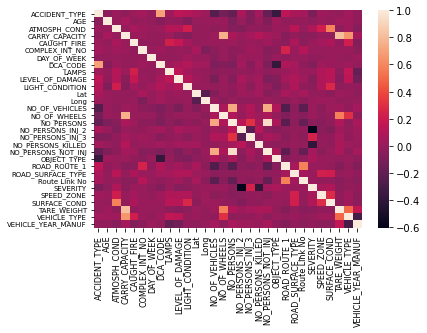

In [112]:
heat_plot = sns.heatmap(d_plot.corr(), xticklabels=True, yticklabels=True)
heat_plot.set_xticklabels(heat_plot.get_xmajorticklabels(), fontsize = 8)
heat_plot.set_yticklabels(heat_plot.get_ymajorticklabels(), fontsize = 7)
heat_plot_fig = heat_plot.get_figure()

In [63]:
m['ACCIDENT_TYPE'].value_counts()

1    3659035
4     466051
2     155014
6      42563
8      41778
5      12287
7       8773
3       8322
9        646
Name: ACCIDENT_TYPE, dtype: int64

In [113]:
heat_plot_fig.savefig('Corr_plot.png', dpi=600, bbox_inches='tight', pad_inches=2)
# We cannot see any strong correlations with fatal/severe accidents at a first glance

### Some introductory numbers

In [782]:
accidents = d['ACCIDENT'].copy()

In [767]:
# Accidents per year
accidents.shape[0]/len(accidents_month_year.columns)

13580.533333333333

In [768]:
# Deaths per year
accidents['NO_PERSONS_KILLED'].sum()/len(accidents_month_year.columns)

268.93333333333334

In [769]:
# Police attendance per year
accidents.POLICE_ATTEND.value_counts()[1]/len(accidents_month_year.columns)

10105.2

In [770]:
# Number of rows
counter = 0
for i in d:
    counter += d[i].shape[0]
print(counter)

2892547


In [771]:
# Number of features
counter = 0
for i in d:
    counter += d[i].shape[1]
print(counter - len(d) + 1 - 2) # since VEHICLE_ID and PERSON_ID exist in two tables

122


### Evolution over time

In [783]:
date_format = pd.to_datetime(d['ACCIDENT']['ACCIDENTDATE'], infer_datetime_format=True)
accidents['YEAR'] = pd.DatetimeIndex(date_format).year
accidents['MONTH'] = pd.DatetimeIndex(date_format).month
accidents['WEEK_DAY'] = pd.DatetimeIndex(date_format).weekday
accidents.pop('ACCIDENTDATE')

0         13/01/2006
1         13/01/2006
2         14/01/2006
3         14/01/2006
4         14/01/2006
             ...    
203703     1/11/2020
203704     1/11/2020
203705     1/11/2020
203706     1/11/2020
203707     4/11/2020
Name: ACCIDENTDATE, Length: 203708, dtype: object

In [774]:
# Accidents
accidents_year = accidents['YEAR']
accidents_year = pd.DataFrame(pd.DataFrame(accidents_year).groupby('YEAR').size()).iloc[:,0]
# accidents_year.plot.line(color='#DD5F63', linewidth=3, title='Accidents over time', xlabel='Year', ylabel='Accidents')

In [775]:
# Fatal accidents
fatalities_year = accidents[accidents['SEVERITY'] == 1]['YEAR']
fatalities_year = pd.DataFrame(pd.DataFrame(fatalities_year).groupby('YEAR').size()).iloc[:,0]

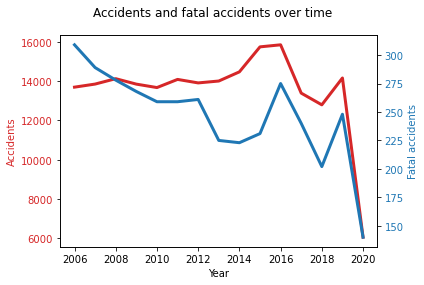

In [776]:
# Plotting of accidents and fatal accidents
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Accidents', color=color)
ax1.plot(accidents_year, color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fatal accidents', color=color)  # we already handled the x-label with ax1
ax2.plot(fatalities_year, color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
fig.suptitle('Accidents and fatal accidents over time')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('Evolution_accident-fatalities.png', dpi=600)
plt.show()

# We can see that while accidents have been more or less steady (until covid), fatal ones have been on the decline

<AxesSubplot:title={'center':'Monthly values over time'}, xlabel='MONTH'>

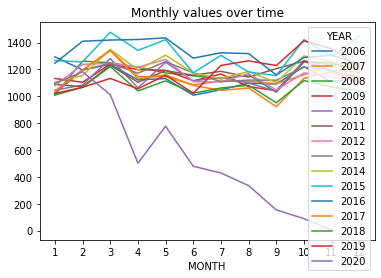

In [757]:
# Month over the years (e.g. for capacity planning)
accidents_month = accidents[['MONTH', 'YEAR']]
accidents_month.groupby(['MONTH', 'YEAR']).size()
accidents_month_year = accidents_month.pivot_table(index='MONTH', columns='YEAR', aggfunc=len)
accidents_month_year.plot(xticks=range(1,13), title='Monthly values over time')

<AxesSubplot:title={'center':'Monthly averages'}, xlabel='MONTH', ylabel='Accidents'>

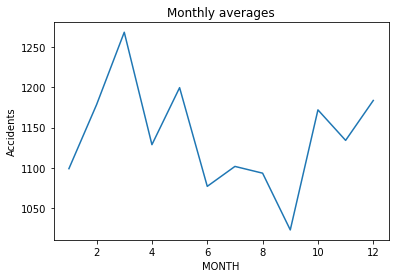

In [243]:
accidents_month_year_average = accidents_month_year.mean(axis=1)
accidents_month_year_average.plot(title='Monthly averages', ylabel='Accidents')

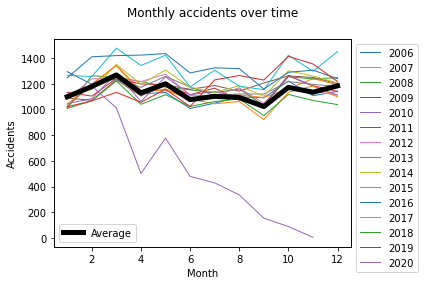

In [785]:
# Monthly values over years and average thereof (black)
fig, ax1 = plt.subplots()

#color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Accidents')
ax1.plot(accidents_month_year, linewidth=1)
ax1.legend(accidents_month_year.columns, bbox_to_anchor=(1, 1))
ax1.tick_params(axis='y')

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fatal accidents', color=color)  # we already handled the x-label with ax1
ax2.plot(accidents_month_year_average, color='Black', linewidth=5)
ax2.legend(['Average'], loc='lower left')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_visible(False)
fig.suptitle('Monthly accidents over time')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Months_over_years.png', dpi=600)
plt.show()

#### Weekday total 

In [810]:
# Accidents

In [807]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

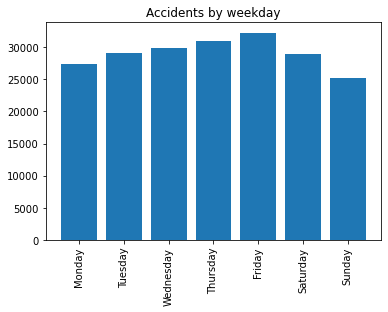

In [849]:
weekly_accidents = accidents['WEEK_DAY'].value_counts()
plt.bar(weekly_accidents.index, 
        weekly_accidents)
plt.xticks(range(7), days, rotation=90)
plt.title('Accidents by weekday')
# plt.savefig('Accidents_by_weekday.png', dpi=600, bbox_inches='tight')

In [ ]:
# Fatal accidents

In [833]:
fatal_accidents = accidents[accidents['SEVERITY'] == 1]

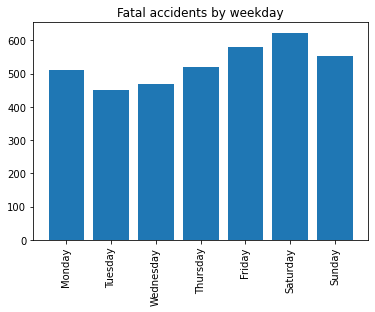

In [847]:
weekly_fatal_accidents = fatal_accidents['WEEK_DAY'].value_counts()
plt.bar(weekly_fatal_accidents.index, 
        weekly_fatal_accidents)
plt.xticks(range(7), days, rotation=90)
plt.title('Fatal accidents by weekday')
# plt.savefig('Fatal accidents_by_weekday.png', dpi=600, bbox_inches='tight')

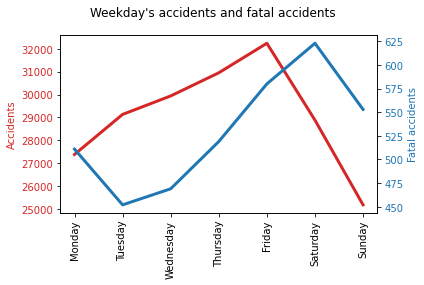

In [846]:
# Plotting of accidents and fatal accidents by weekday
fig, ax1 = plt.subplots()

color = 'tab:red'
#ax1.set_xlabel('Year')
ax1.set_ylabel('Accidents', color=color)
ax1.plot(weekly_accidents.sort_index(), color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(7))
ax1.set_xticklabels(days, rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fatal accidents', color=color)  # we already handled the x-label with ax1
ax2.plot(weekly_fatal_accidents.sort_index(), color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
fig.suptitle('Weekday\'s accidents and fatal accidents')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('Evolution_accident-fatalities.png', dpi=600)
plt.show()
# Bar charts make more sense

#### Road Type

In [ ]:
# Accidents

In [937]:
accidents_location = pd.merge(accidents, d['ACCIDENT_LOCATION'][['ACCIDENT_NO', 'ROAD_TYPE', 'ROAD_ROUTE_1']],
                              on='ACCIDENT_NO')

In [938]:
accidents_location['ROAD_TYPE'].value_counts().iloc[:5]  # Contradicting values for highway and freeway compared to ROAD_ROUTE_1

ROAD       101946
STREET      46541
HIGHWAY     19241
FREEWAY      7647
AVENUE       5535
Name: ROAD_TYPE, dtype: int64

In [958]:
relevant_roads = [9, 5, 2, 4, 7, 3]
relevant_roads_desc = ['Unclassified', 'Main Rds', 'Freeways/\nHighways', 'Tourist Rds', 'Ramps', 'Forest Rds']
relevant_roads_translation = dict(zip(relevant_roads, relevant_roads_desc))

In [959]:
road_route = accidents_location['ROAD_ROUTE_1'].dropna().apply(rr_check).value_counts().sort_index().reset_index()
road_route = road_route.rename(columns={'index': 'Road_Route', 'ROAD_ROUTE_1':'Count'})
road_route = road_route[road_route['Road_Route'].isin(relevant_roads)]
road_route['Road_Route'] = road_route['Road_Route'].apply(lambda x: relevant_roads_translation[x])

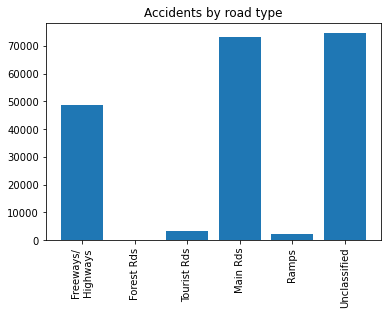

In [961]:
plt.bar(road_route.Road_Route, 
        road_route.Count)
plt.xticks(rotation=90)
plt.title('Accidents by road type')
# plt.savefig('Accidents_road_type.png', dpi=600, bbox_inches='tight')

In [952]:
# Fatal accidents

In [963]:
fatal_accidents_location = accidents_location[accidents_location['SEVERITY'] == 1]

In [964]:
fatal_road_route = fatal_accidents_location['ROAD_ROUTE_1'].dropna().apply(rr_check).value_counts().sort_index().reset_index()
fatal_road_route = fatal_road_route.rename(columns={'index': 'Road_Route', 'ROAD_ROUTE_1':'Count'})
fatal_road_route = fatal_road_route[fatal_road_route['Road_Route'].isin(relevant_roads)]
fatal_road_route['Road_Route'] = fatal_road_route['Road_Route'].apply(lambda x: relevant_roads_translation[x])

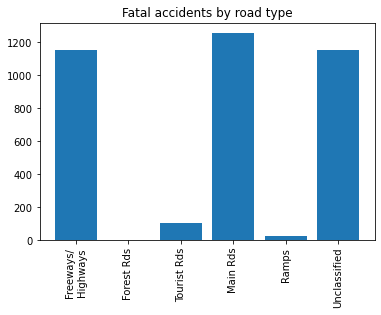

In [965]:
plt.bar(fatal_road_route.Road_Route, 
        fatal_road_route.Count)
plt.xticks(rotation=90)
plt.title('Fatal accidents by road type')
# plt.savefig('Fatal_accidents_road_type.png', dpi=600, bbox_inches='tight')

#### Road condition

In [ ]:
# Road Surface Type

In [ ]:
# Accidents

In [968]:
accidents_surface_type = pd.merge(accidents, d['VEHICLE'][['ACCIDENT_NO', 'Road Surface Type Desc']],
                              on='ACCIDENT_NO')

In [972]:
surface_types = accidents_surface_type['Road Surface Type Desc'].value_counts().sort_index()

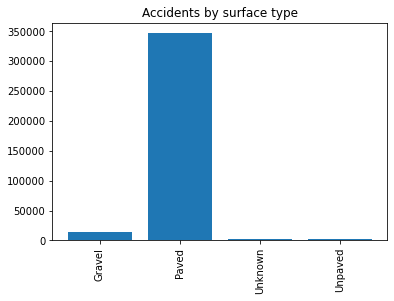

In [988]:
plt.bar(surface_types.index, 
        surface_types)
plt.xticks(rotation=90)
plt.title('Accidents by surface type')
plt.savefig('Accidents_surface_type.png', dpi=600, bbox_inches='tight')

In [974]:
# Ratio fatal accidents vs accidents

In [975]:
fatal_accidents_surface_type = accidents_surface_type[accidents_surface_type['SEVERITY'] == 1]

In [976]:
fatal_surface_types = fatal_accidents_surface_type['Road Surface Type Desc'].value_counts().sort_index()

In [986]:
surface_types_ratio = surface_types.combine(fatal_surface_types, lambda x, y: y/x)

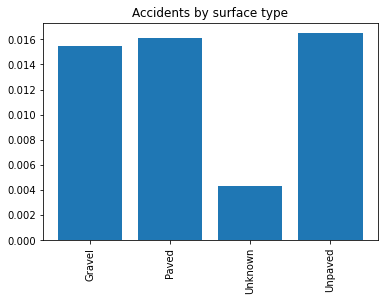

In [989]:
plt.bar(surface_types_ratio.index, 
        surface_types_ratio)
plt.xticks(rotation=90)
plt.title('Accidents by surface type')
plt.savefig('Ratio_surface_type.png', dpi=600, bbox_inches='tight')

In [ ]:
# Surface Condition

In [ ]:
# Accidents

In [996]:
accidents_condition = pd.merge(accidents, d['ROAD_SURFACE_COND'][['ACCIDENT_NO', 'Surface Cond Desc']],
                              on='ACCIDENT_NO')
surface_cond = accidents_condition['Surface Cond Desc'].value_counts().sort_index()

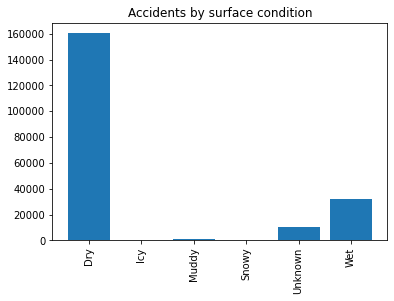

In [997]:
plt.bar(surface_cond.index, 
        surface_cond)
plt.xticks(rotation=90)
plt.title('Accidents by surface condition')
# plt.savefig('Accidents_surface_cond.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio fatal accidents vs accidents

In [999]:
fatal_accidents_condition = accidents_condition[accidents_condition['SEVERITY'] == 1]
fatal_surface_cond = fatal_accidents_condition['Surface Cond Desc'].value_counts().sort_index()

In [1000]:
surface_cond_ratio = surface_cond.combine(fatal_surface_cond, lambda x, y: y/x)

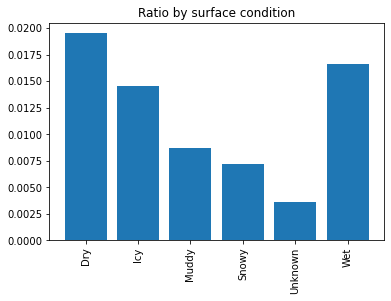

In [1002]:
plt.bar(surface_cond_ratio.index, 
        surface_cond_ratio)
plt.xticks(rotation=90)
plt.title('Ratio by surface condition')
# plt.savefig('Ratio_surface_cond.png', dpi=600, bbox_inches='tight')

In [ ]:
# Weather

In [ ]:
# Accidents

In [1007]:
accidents_atm = pd.merge(accidents, d['ATMOSPHERIC_COND'][['ACCIDENT_NO', 'Atmosph Cond Desc']], on='ACCIDENT_NO')
atm = accidents_atm['Atmosph Cond Desc'].value_counts().sort_index()

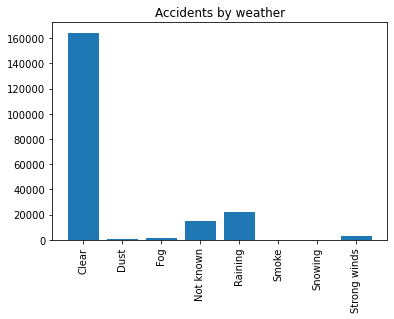

In [1011]:
plt.bar(atm.index, 
        atm)
plt.xticks(rotation=90)
plt.title('Accidents by weather')
# plt.savefig('Accidents_weather.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio fatal accidents vs accidents

In [1012]:
fatal_accidents_atm = accidents_atm[accidents_atm['SEVERITY'] == 1]
fatal_atm = fatal_accidents_atm['Atmosph Cond Desc'].value_counts().sort_index()
atm_ratio = atm.combine(fatal_atm, lambda x, y: y/x)

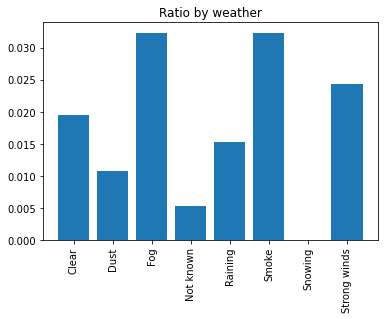

In [1013]:
plt.bar(atm_ratio.index, 
        atm_ratio)
plt.xticks(rotation=90)
plt.title('Ratio by weather')
# plt.savefig('Ratio_weather.png', dpi=600, bbox_inches='tight')

### Speed

In [ ]:
# Accidents

In [1031]:
accidents_speed = accidents[accidents['SPEED_ZONE'] < 200]
speed = accidents_speed['SPEED_ZONE'].value_counts().sort_index()

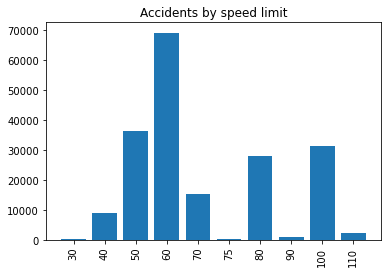

In [1037]:
plt.bar(speed.index.astype('str'), 
        speed)
plt.xticks(rotation=90)
plt.title('Accidents by speed limit')
# plt.savefig('Accidents_speed_limit.png', dpi=600, bbox_inches='tight')

In [1038]:
# Ratio fatal accidents vs accidents

In [1039]:
fatal_accidents_speed = accidents_speed[accidents_speed['SEVERITY'] == 1]
fatal_speed = fatal_accidents_speed['SPEED_ZONE'].value_counts().sort_index()
speed_ratio = speed.combine(fatal_speed, lambda x, y: y/x)

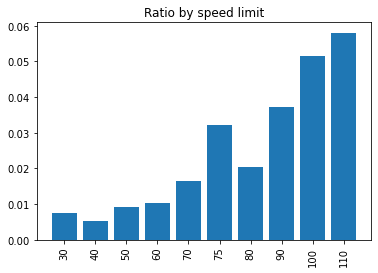

In [1040]:
plt.bar(speed_ratio.index.astype('str'), 
        speed_ratio)
plt.xticks(rotation=90)
plt.title('Ratio by speed limit')
# plt.savefig('Ratio_speed_limit.png', dpi=600, bbox_inches='tight')

#### Collision point

In [ ]:
# Accidents

In [1048]:
accident_collision = pd.merge(accidents, d['ACCIDENT_EVENT'][['ACCIDENT_NO', 'Vehicle 1 Coll Pt Desc']], on='ACCIDENT_NO')
accident_collision = accident_collision[accident_collision['Vehicle 1 Coll Pt Desc'] != ' ']
collision = accident_collision['Vehicle 1 Coll Pt Desc'].value_counts().sort_index()

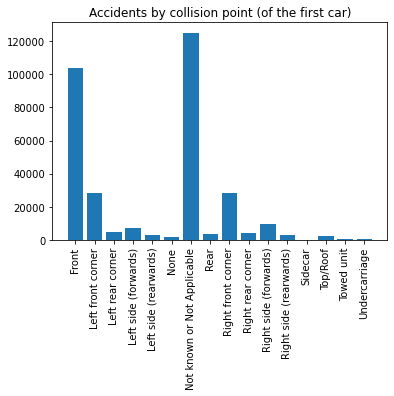

In [1054]:
plt.bar(collision.index, 
        collision)
plt.xticks(rotation=90)
plt.title('Accidents by collision point (of the first car)')
# plt.savefig('Accidents_collision.png', dpi=600, bbox_inches='tight')

In [1055]:
# Ratio fatal accidents vs accidents

In [1056]:
fatal_accident_collision = accident_collision[accident_collision['SEVERITY'] == 1]
fatal_collision = fatal_accident_collision['Vehicle 1 Coll Pt Desc'].value_counts().sort_index()
collision_ratio = collision.combine(fatal_collision, lambda x, y: y/x)

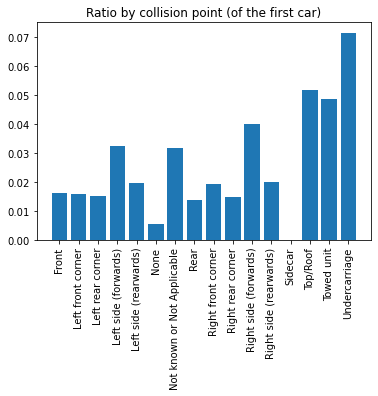

In [1057]:
plt.bar(collision_ratio.index, 
        collision_ratio)
plt.xticks(rotation=90)
plt.title('Ratio by collision point (of the first car)')
# plt.savefig('Ratio_collision.png', dpi=600, bbox_inches='tight')

#### Trailer

In [1069]:
trailers_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
trailers_desc = ['Caravan', 'Trailer (general)', 'Trailer (boat)', 'Horse float', 'Machinery', 'Farm equipment',
                 'Unknown', 'Not applicable', 'Trailer (Exempt)', 'Semi Trailer', 'Pig Trailer', 'Dog Trailer']
trailer_translation = dict(zip(trailers_categories, trailers_desc))

In [1076]:
accidents_trailer = pd.merge(accidents, d['VEHICLE'][['ACCIDENT_NO', 'TRAILER_TYPE']],
                              on='ACCIDENT_NO')
accidents_trailer = accidents_trailer[accidents_trailer['TRAILER_TYPE'] != ' ']
accidents_trailer = accidents_trailer[accidents_trailer['TRAILER_TYPE'] != 'H']
accidents_trailer['TRAILER_TYPE'] = accidents_trailer['TRAILER_TYPE'].apply(lambda x: trailer_translation[x])
trailer = accidents_trailer['TRAILER_TYPE'].value_counts().sort_index()

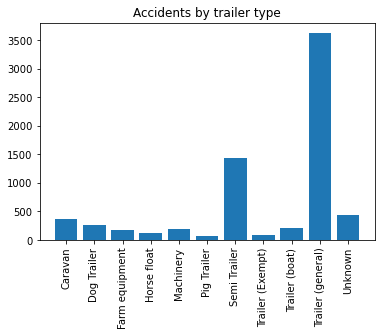

In [1087]:
plt.bar(trailer.index, 
        trailer)
plt.xticks(rotation=90)
plt.title('Accidents by trailer type')
# plt.savefig('Accidents_trailer.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio fatal accidents vs accidents

In [1084]:
fatal_accidents_trailer = accidents_trailer[accidents_trailer['SEVERITY'] == 1]
fatal_trailer = fatal_accidents_trailer['TRAILER_TYPE'].value_counts().sort_index()
trailer_ratio = trailer.combine(fatal_trailer, lambda x, y: y/x)

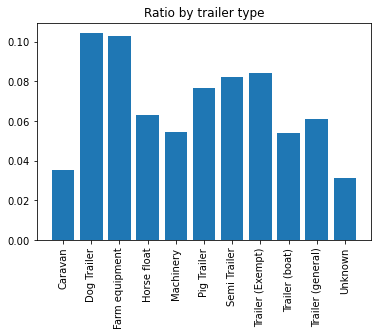

In [1088]:
plt.bar(trailer_ratio.index, 
        trailer_ratio)
plt.xticks(rotation=90)
plt.title('Ratio by trailer type')
# plt.savefig('Ratio_trailer.png', dpi=600, bbox_inches='tight')

#### Severity

In [ ]:
# Accidents

In [1100]:
severity_categories = [1, 2, 3, 4]
severity_desc = ['Fatal', 'Severe Inj.', 'Other Inj.', 'No Inj.']
severity_translation = dict(zip(severity_categories, severity_desc))

In [1101]:
accidents_severity = accidents['SEVERITY']
accidents_severity = accidents_severity.apply(lambda x: severity_translation[x])
severity = accidents_severity.value_counts().sort_index()

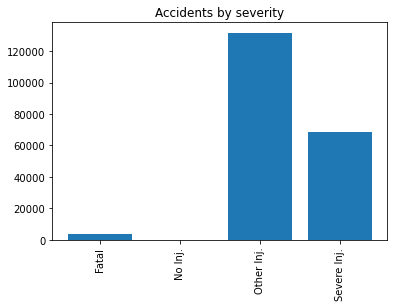

In [1107]:
plt.bar(severity.index, 
        severity)
plt.xticks(rotation=90)
plt.title('Accidents by severity')
# plt.savefig('Accidents_severity.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio fatal vs all accidents

In [1105]:
severity['Fatal']/len(accidents_severity)

0.018197616195731143

#### Caught fire

In [ ]:
# Accidents

In [1115]:
accidents_fire = pd.merge(accidents, d['VEHICLE'][['ACCIDENT_NO', 'CAUGHT_FIRE']],
                              on='ACCIDENT_NO')
accidents_fire['CAUGHT_FIRE'] = accidents_fire['CAUGHT_FIRE'].apply(c_checks)
fire = accidents_fire['CAUGHT_FIRE'].value_counts().sort_index()

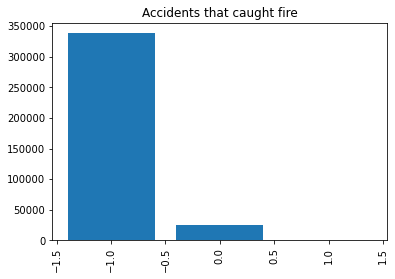

In [1120]:
plt.bar(fire.index, 
        fire)
plt.xticks(rotation=90)
plt.title('Accidents that caught fire')
# plt.savefig('Accidents_fire.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio fatal vs all accidents

In [1117]:
fatal_accidents_fire = accidents_fire[accidents_fire['SEVERITY'] == 1]
fatal_fire = fatal_accidents_fire['CAUGHT_FIRE'].value_counts().sort_index()
fire_ratio = fire.combine(fatal_fire, lambda x, y: y/x)

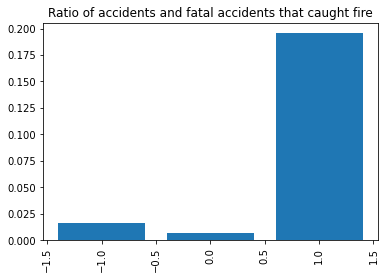

In [1119]:
plt.bar(fire_ratio.index, 
        fire_ratio)
plt.xticks(rotation=90)
plt.title('Ratio of accidents and fatal accidents that caught fire')
# plt.savefig('Ratio_fire.png', dpi=600, bbox_inches='tight')

#### Light condition

In [ ]:
# Accidents

In [1134]:
light_categories = [1, 2, 3, 4, 5, 6, 9]
light_desc = ['Day', 'Dusk/dawn', 'Dark w. lights', 'Dark lights off', 'Dark no lights', 'Dark lights\nunknown', 'Uknown']
light_translation = dict(zip(light_categories, light_desc))

In [1135]:
accident_lights = accidents[accidents['LIGHT_CONDITION'] != 9]
accident_lights['LIGHT_CONDITION'] = accident_lights['LIGHT_CONDITION'].apply(lambda x: light_translation[x])
lights = accident_lights['LIGHT_CONDITION'].value_counts().sort_index()

/var/folders/78/lv70vftj3nl2dv5mkdv90wlm0000gn/T/ipykernel_63152/3646005004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_lights['LIGHT_CONDITION'] = accident_lights['LIGHT_CONDITION'].apply(lambda x: light_translation[x])


Text(0.5, 1.0, 'Accidents light condition')

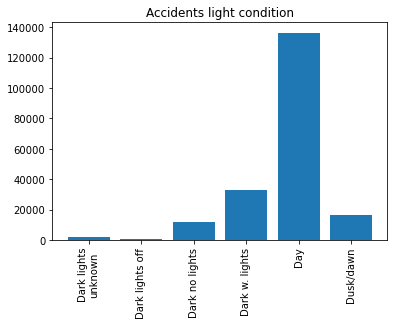

In [1136]:
plt.bar(lights.index, 
        lights)
plt.xticks(rotation=90)
plt.title('Accidents light condition')
# plt.savefig('Accidents_light.png', dpi=600, bbox_inches='tight')

In [1137]:
# Ratio

In [1138]:
fatal_accident_lights = accident_lights[accident_lights['SEVERITY'] == 1]
fatal_lights = fatal_accident_lights['LIGHT_CONDITION'].value_counts().sort_index()
lights_ratio = lights.combine(fatal_lights, lambda x, y: y/x)

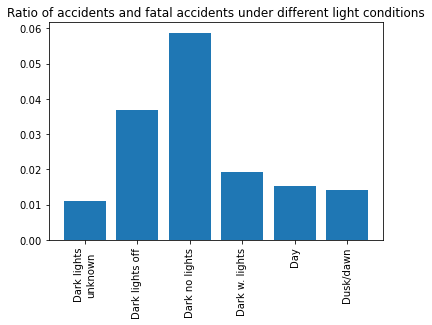

In [1139]:
plt.bar(lights_ratio.index, 
        lights_ratio)
plt.xticks(rotation=90)
plt.title('Ratio of accidents and fatal accidents under different light conditions')
# plt.savefig('Ratio_light.png', dpi=600, bbox_inches='tight')

#### Car lights

In [ ]:
# Accidents

In [1150]:
accidents_lamps = pd.merge(accidents, d['VEHICLE'][['ACCIDENT_NO', 'LAMPS']],
                              on='ACCIDENT_NO')
accidents_lamps = accidents_lamps[accidents_lamps['LAMPS'] != 9]
accidents_lamps['LAMPS'] = accidents_lamps['LAMPS'].apply(l_check)
lamps = accidents_lamps['LAMPS'].value_counts().sort_index()

Text(0.5, 1.0, 'Accidents lamps on or off')

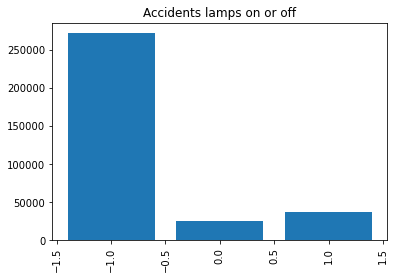

In [1151]:
plt.bar(lamps.index, 
        lamps)
plt.xticks(rotation=90)
plt.title('Accidents lamps on or off')
# plt.savefig('Accidents_lamps.png', dpi=600, bbox_inches='tight')

In [1152]:
# Ratio

In [1153]:
fatal_accidents_lamps = accidents_lamps[accidents_lamps['SEVERITY'] == 1]
fatal_lamps = fatal_accidents_lamps['LAMPS'].value_counts().sort_index()
lamps_ratio = lamps.combine(fatal_lamps, lambda x, y: y/x)

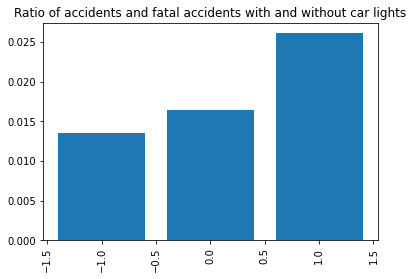

In [1157]:
plt.bar(lamps_ratio.index, 
        lamps_ratio)
plt.xticks(rotation=90)
plt.title('Ratio of accidents and fatal accidents with and without car lights')
# plt.savefig('Ratio_lamps.png', dpi=600, bbox_inches='tight')

#### Ejection

In [ ]:
# Accidents

In [1171]:
accidents_ejected = pd.merge(accidents, d['PERSON'][['ACCIDENT_NO', 'EJECTED_CODE']], on='ACCIDENT_NO')
accidents_ejected = accidents_ejected[accidents_ejected['EJECTED_CODE'] != ' ']
accidents_ejected = accidents_ejected[accidents_ejected['EJECTED_CODE'] != '9']
ejected = accidents_ejected['EJECTED_CODE'].value_counts().sort_index()

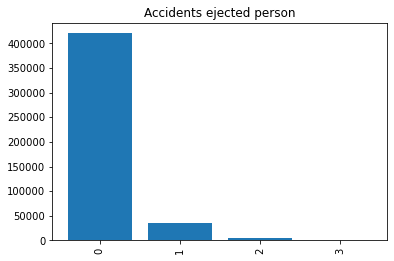

In [1175]:
plt.bar(ejected.index, 
        ejected)
plt.xticks(rotation=90)
plt.title('Accidents ejected person')
# plt.savefig('Accidents_ejection.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio

In [1173]:
fatal_accidents_ejected = accidents_ejected[accidents_ejected['SEVERITY'] == 1]
fatal_ejected = fatal_accidents_ejected['EJECTED_CODE'].value_counts().sort_index()
ejected_ratio = ejected.combine(fatal_ejected, lambda x, y: y/x)

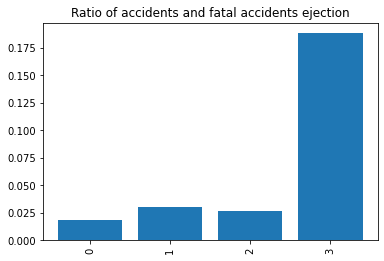

In [1176]:
plt.bar(ejected_ratio.index, 
        ejected_ratio)
plt.xticks(rotation=90)
plt.title('Ratio of accidents and fatal accidents ejection')
# plt.savefig('Ratio_ejection.png', dpi=600, bbox_inches='tight')

#### Safety measures

In [ ]:
# Accidents

In [1192]:
sorted(accidents_safety['HELMET_BELT_WORN'].unique())

['1', '2', '3', '4', '5', '6', '7', '8']

In [ ]:
Code Description 1 Seatbelt worn 2 Seatbelt not worn 3 Child restraint worn 4 Child restraint not worn 
5 Seatbelt/restraint not fitted 6 Crash helmet worn 7 Crash helmet not worn 8 Not appropriate 9 Not known 

In [1199]:
safety_categories = ['1', '2', '3', '4', '5', '6', '7']
safety_desc = ['Seatbelt', 'No seatbelt', 'Child restraint', 'No child restraint', 'Seatbelt not fitted',
              'Crash helmet', 'No crash helmet']
safety_translation = dict(zip(safety_categories, safety_desc))

In [1200]:
accidents_safety = pd.merge(accidents, d['PERSON'][['ACCIDENT_NO', 'HELMET_BELT_WORN']], on='ACCIDENT_NO')
accidents_safety = accidents_safety[accidents_safety['HELMET_BELT_WORN'] != ' ']
accidents_safety['HELMET_BELT_WORN'] = accidents_safety['HELMET_BELT_WORN'].apply(int)
accidents_safety = accidents_safety[accidents_safety['HELMET_BELT_WORN'] != 9]
accidents_safety = accidents_safety[accidents_safety['HELMET_BELT_WORN'] != 8]
accidents_safety['HELMET_BELT_WORN'] = accidents_safety['HELMET_BELT_WORN'].apply(str)
accidents_safety['HELMET_BELT_WORN'] = accidents_safety['HELMET_BELT_WORN'].apply(lambda x: safety_translation[x])
safety = accidents_safety['HELMET_BELT_WORN'].value_counts().sort_index()

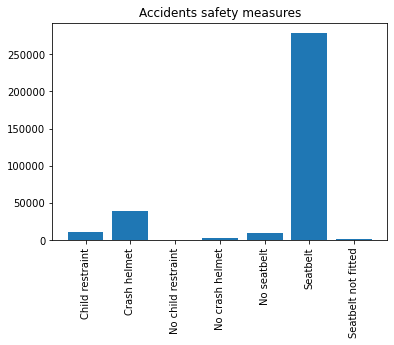

In [1202]:
plt.bar(safety.index, 
        safety)
plt.xticks(rotation=90)
plt.title('Accidents safety measures')
# plt.savefig('Accidents_safety.png', dpi=600, bbox_inches='tight')

In [ ]:
# Ratio

In [1203]:
fatal_accidents_safety = accidents_safety[accidents_safety['SEVERITY'] == 1]
fatal_safety = fatal_accidents_safety['HELMET_BELT_WORN'].value_counts().sort_index()
safety_ratio = safety.combine(fatal_safety, lambda x, y: y/x)

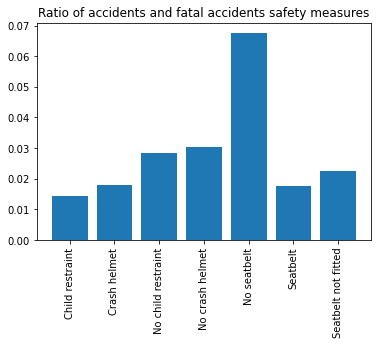

In [1205]:
plt.bar(safety_ratio.index, 
        safety_ratio)
plt.xticks(rotation=90)
plt.title('Ratio of accidents and fatal accidents safety measures')
# plt.savefig('Ratio_safety.png', dpi=600, bbox_inches='tight')

### Creating geographical overviews

#### LGA MAP

In [611]:
# Accidents

In [379]:
# Merge ACCIDENT and necessary LGA data
accidents_lga = pd.merge(accidents, d['NODE'][['ACCIDENT_NO', 'LGA_NAME']], on='ACCIDENT_NO')

In [505]:
lga_gdf = gpd.read_file('1270055003_lga_2020_aust_shp/LGA_2020_AUST.shp') #load the data using Geopandas
lga_gdf = lga_gdf[lga_gdf['STE_NAME16']=='Victoria'] #Select the data for the state of Victoria
lga_gdf['LGA_CODE20'] = lga_gdf['LGA_CODE20'].astype('str') # we will join on this axis, so both dataframes need this to be the same type
lga_gdf['LGA_NAME20'] = [re.sub(r' \(.*\)', '', i).upper() for i in lga_gdf['LGA_NAME20']]
lga_gdf['LGA_NAME20'] = [re.sub(r'GREATER ', '', i).upper() for i in lga_gdf['LGA_NAME20']]
lga_gdf['LGA_NAME20'] = [re.sub(r'-', ' ', i).upper() for i in lga_gdf['LGA_NAME20']]

In [578]:
# Merging geo information with accident data
accidents_lga_merged = pd.merge(lga_gdf[['geometry', 'LGA_NAME20']], accidents_lga, left_on='LGA_NAME20', right_on='LGA_NAME', how='outer')
accidents_lga_merged = accidents_lga_merged.dropna(subset=['LGA_NAME'])  # If we dropped na for LGA_NAME20, there we be no blank spots on the map
# Grouping by LGA_NAME20 and merging with geo information
LGA_counts = pd.DataFrame(accidents_lga_merged[['LGA_NAME20']].value_counts()).rename(columns={0: 'Count'}).reset_index()
LGA_counts_merged = pd.merge(lga_gdf[['geometry', 'LGA_NAME20']], LGA_counts, 
                             left_on='LGA_NAME20', right_on='LGA_NAME20', how='outer')

<AxesSubplot:title={'center':'Accidents by LGA'}>

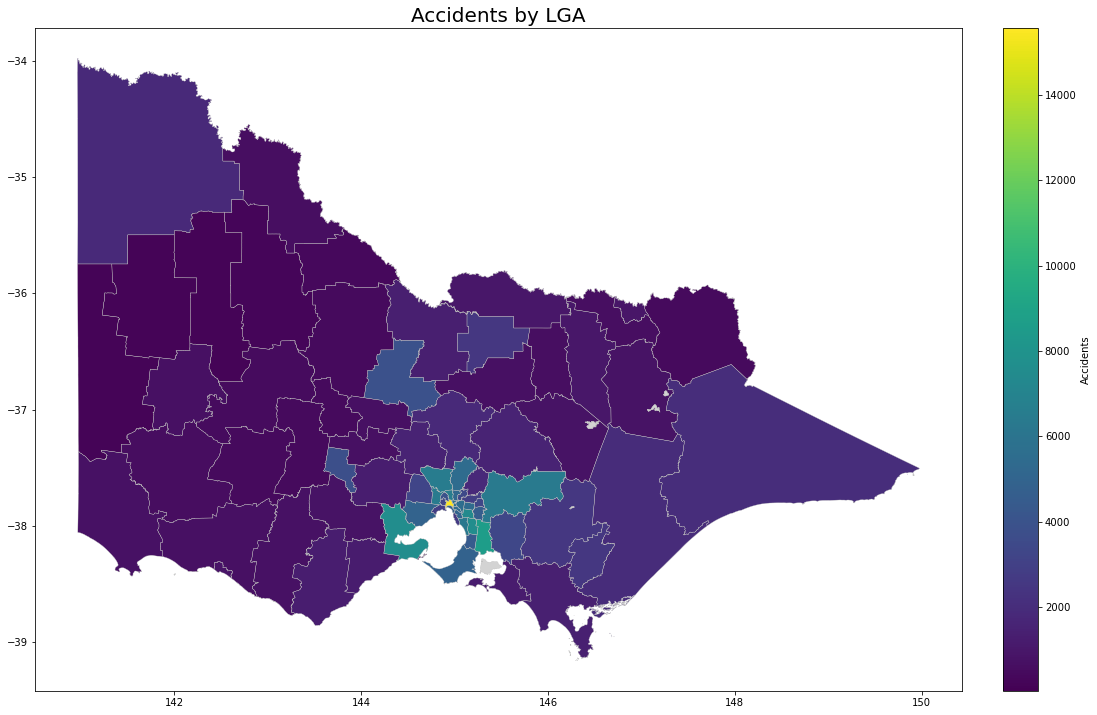

In [579]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = LGA_counts_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Accidents by LGA', {'fontsize': 20})
tmp.plot(column='Count', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Accidents_by_LGA.png", dpi=600) 

In [586]:
# LGA_counts_merged.sort_values('Count')  # To get min and max values

In [612]:
# Fatal accidents

In [617]:
fatal_accidents_lga = accidents_lga[accidents_lga['SEVERITY'] == 1]

In [630]:
fatal_lga_count = pd.DataFrame(fatal_accidents_lga[['LGA_NAME']].value_counts()).reset_index().rename(columns={0: 'Count'})
fatal_lga_count_merged = pd.merge(lga_gdf[['geometry', 'LGA_NAME20']], fatal_lga_count,
                                  left_on='LGA_NAME20', right_on='LGA_NAME', how='outer').dropna(subset='geometry')

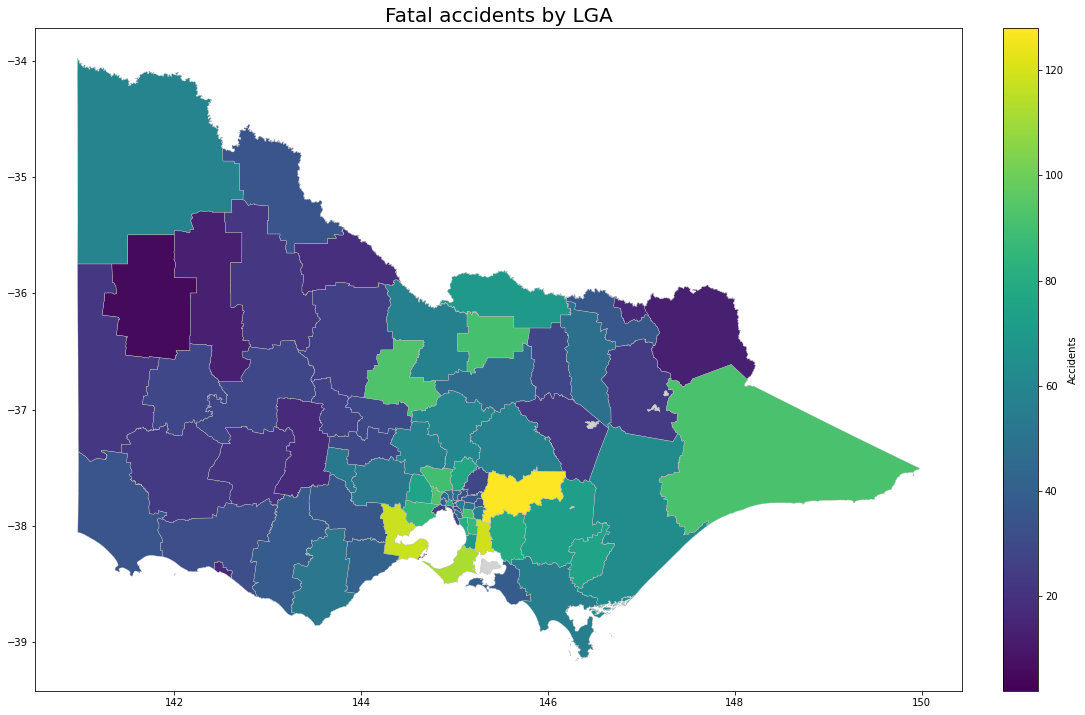

In [633]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = fatal_lga_count_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Fatal accidents by LGA', {'fontsize': 20})
tmp.plot(column='Count', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Fatal_accidents_by_LGA.png", dpi=600)

#### Region map

In [580]:
geo_region = gpd.read_file('Regional Boundaries - DOT - GeoJSON.geojson')

In [581]:
# Translating certain region names
geo_region.loc[2, 'REG_NAME'] = 'SOUTH WESTERN REGION'
geo_region.loc[3, 'REG_NAME'] = 'EASTERN REGION'
geo_region.loc[4, 'REG_NAME'] = 'WESTERN REGION'
geo_region.loc[5, 'REG_NAME'] = 'NORTH EASTERN REGION'
geo_region.loc[6, 'REG_NAME'] = 'NORTHERN REGION'

In [587]:
accidents_region = pd.merge(accidents, d['NODE'][['ACCIDENT_NO', 'REGION_NAME']], on='ACCIDENT_NO')

In [590]:
region_counts = pd.DataFrame(accidents_region[['REGION_NAME']].value_counts()).reset_index().rename(columns={0: 'Count'})

In [604]:
region_counts_merged = pd.merge(geo_region[['geometry', 'REG_NAME']], region_counts,
                                left_on='REG_NAME', right_on='REGION_NAME', how='outer').dropna(subset='REG_NAME')

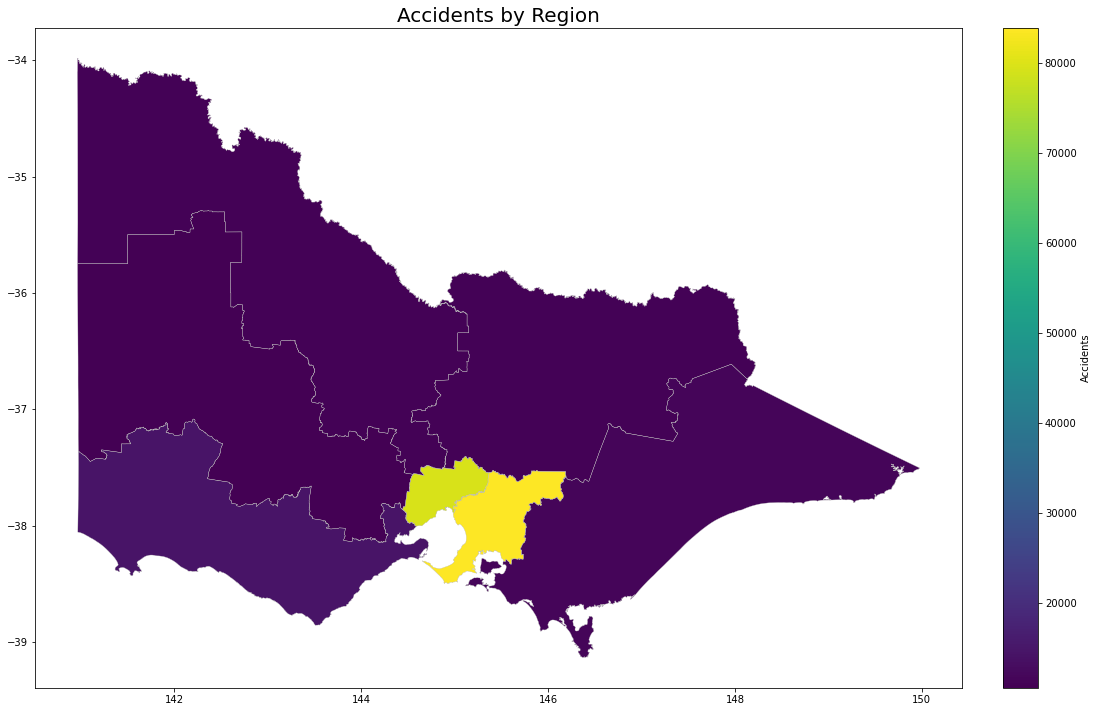

In [608]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = region_counts_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Accidents by Region', {'fontsize': 20})
tmp.plot(column='Count', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Accidents_by_region.png", dpi=600) 

In [ ]:
# Fatal accidents

In [638]:
fatal_accidents_region = accidents_region[accidents_region['SEVERITY'] == 1]
fatal_region_count = pd.DataFrame(fatal_accidents_region[['REGION_NAME']].value_counts()).reset_index().rename(columns={0: 'Count'})

In [640]:
fatal_region_counts_merged = pd.merge(geo_region[['geometry', 'REG_NAME']], fatal_region_count,
                                left_on='REG_NAME', right_on='REGION_NAME', how='outer').dropna(subset='REG_NAME')

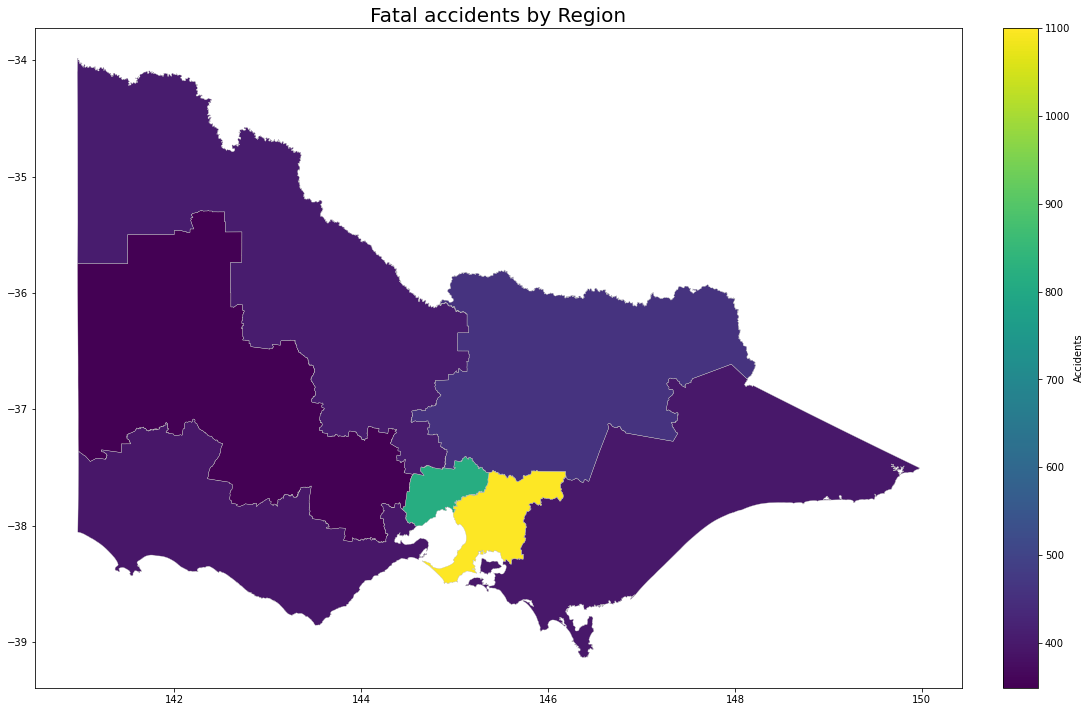

In [644]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = fatal_region_counts_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Fatal accidents by Region', {'fontsize': 20})
tmp.plot(column='Count', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Fatal_accidents_by_region.png", dpi=600)

#### Speed (LGA)

In [728]:
# Accidents

In [715]:
# Create list with average speed per LGA
lga_speeds = [pd.DataFrame(accidents_lga.groupby('LGA_NAME')).iloc[i,1][pd.DataFrame(accidents_lga.groupby('LGA_NAME')).iloc[i,1]['SPEED_ZONE'] < 200]['SPEED_ZONE'].mean() for i in range(1, len(accidents_lga.groupby('LGA_NAME')))]
lga_speeds.insert(0,0)
lga_speeds = pd.DataFrame(lga_speeds).rename(columns={0: 'Avg_Speed'})
lga_speeds = lga_speeds.join(pd.DataFrame(accidents_lga.groupby('LGA_NAME'))).rename(columns={0: 'LGA_NAME'}).iloc[:,:2]

In [722]:
lga_speeds_merged = pd.merge(lga_gdf[['geometry', 'LGA_NAME20']], lga_speeds,
                             left_on='LGA_NAME20', right_on='LGA_NAME', how='outer').dropna(subset=['geometry', 'Avg_Speed'])

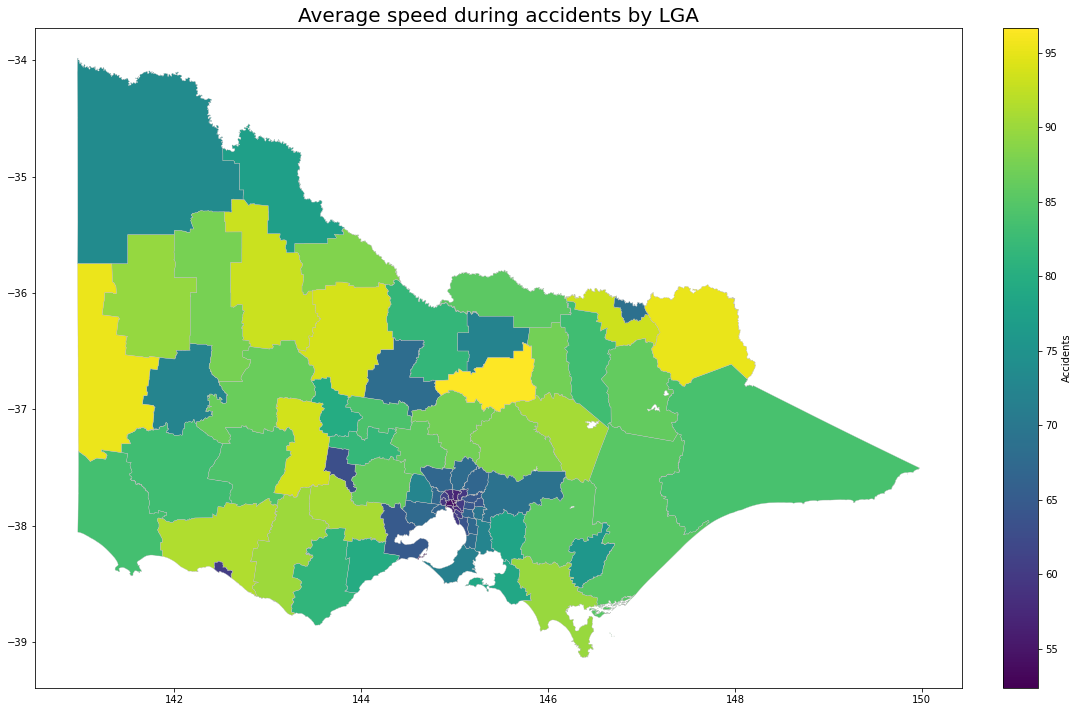

In [742]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = lga_speeds_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Average speed during accidents by LGA', {'fontsize': 20})
tmp.plot(column='Avg_Speed', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Speed_accidents_by_LGA.png", dpi=600)

In [729]:
# Fatal accidents

In [736]:
# Create list with average speed per R
fatal_lga_speeds = [pd.DataFrame(fatal_accidents_lga.groupby('LGA_NAME')).iloc[i,1][pd.DataFrame(fatal_accidents_lga.groupby('LGA_NAME')).iloc[i,1]['SPEED_ZONE'] < 200]['SPEED_ZONE'].mean() for i in range(1, len(fatal_accidents_lga.groupby('LGA_NAME')))]
fatal_lga_speeds = pd.DataFrame(fatal_lga_speeds).rename(columns={0: 'Avg_Speed'})
fatal_lga_speeds = fatal_lga_speeds.join(pd.DataFrame(fatal_accidents_lga.groupby('LGA_NAME'))).rename(columns={0: 'LGA_NAME'}).iloc[:,:2]

In [739]:
fatal_lga_speeds_merged = pd.merge(lga_gdf[['geometry', 'LGA_NAME20']], fatal_lga_speeds,
                                   left_on='LGA_NAME20', right_on='LGA_NAME', how='outer').dropna(subset=['geometry', 'Avg_Speed'])

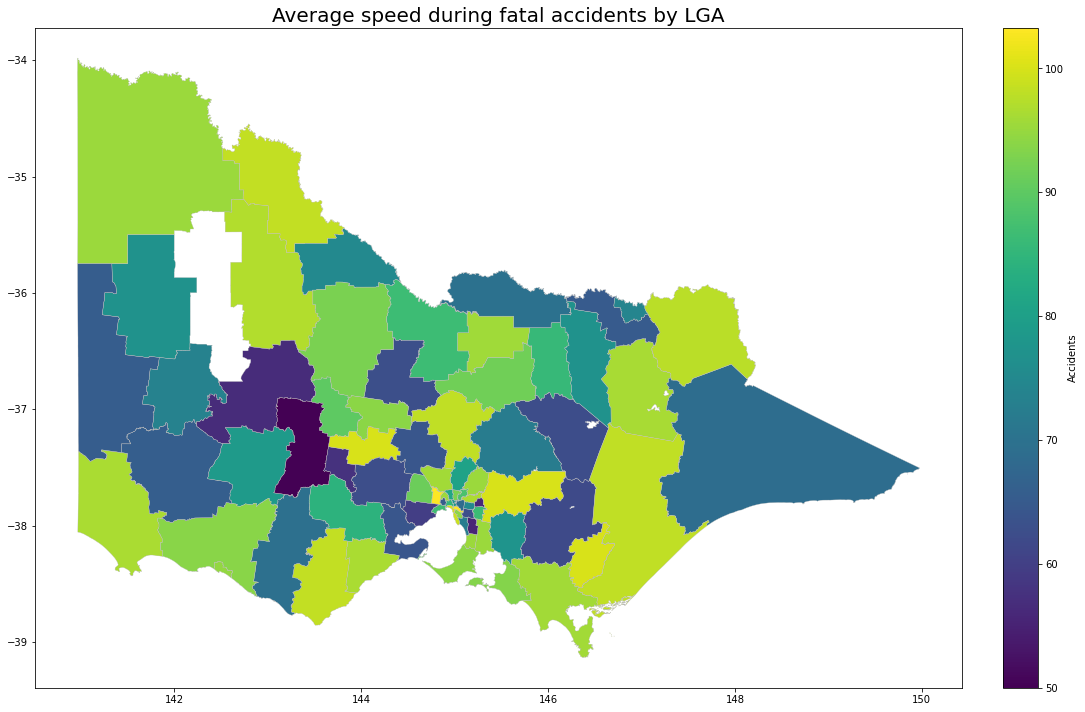

In [743]:
# Plot using geopandas
fig, ax = plt.subplots(1,1, figsize=(20,20))
divider = make_axes_locatable(ax)
tmp = fatal_lga_speeds_merged.copy()
cax = divider.append_axes("right", size="3%", pad=-1)
ax.set_title('Average speed during fatal accidents by LGA', {'fontsize': 20})
tmp.plot(column='Avg_Speed', ax=ax,cax=cax,  legend=True,
         legend_kwds={'label': "Accidents"},
         missing_kwds={"color": "lightgrey"})  # Since the geo info packs all 6 unincorporated areas into one, we leave it blank
tmp.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3)
# fig.savefig("Speed_fatal_accidents_by_LGA.png", dpi=600)

#### Heatmap

In [746]:
# Heatmaps are commented out, since they use up too much space

In [747]:
# Heatmap of all accidents
#location_data = df[['Lat', 'Long']]

In [748]:
#map_accidents = folium.Map(location=[df.loc[1,'Lat'], df.loc[1,'Long']], zoom_start=10)

In [749]:
#HeatMap(location_data, radius=10).add_to(map_accidents)

In [750]:
#map_accidents

In [751]:
#map_accidents.save('Heat_map_accidents.html')

In [752]:
# Heatmap for fatalities
#fatalities = d_plot[d_plot['SEVERITY'] == 1][['Lat', 'Long']]

In [753]:
#map_fatalities = folium.Map(location=[fatalities.iloc[0,0], fatalities.iloc[0, 1]], zoom_start=10)

In [754]:
#HeatMap(fatalities, radius=10).add_to(map_fatalities)

In [755]:
#map_fatalities

In [756]:
#map_fatalities.save('Heat_map_fatal_accidents.html')

### To get a quick overview of a feature

In [1177]:
for i in d:
    search = 'HELMET_BELT_WORN'
    if search in d[i].columns:
        print(i)
        print(pd.isna(d[i][search]).sum())
        print(pd.isna(d[i][search]).sum()/d[i][search].shape[0])
        print(d[i][search].value_counts())

PERSON
0
0.0
1    153121
1    125625
9     62062
9     60764
6     20715
6     18354
8     13628
8     12349
3      5768
2      5236
3      5038
2      3937
7      1278
7      1085
5       959
5       768
4       140
4       107
         14
Name: HELMET_BELT_WORN, dtype: int64


In [1042]:
for i in d:
    search = 'Vehicle 1 Coll Pt Desc'
    if search in d[i].columns:
        print(i)
        print(d[i][search].value_counts())

ACCIDENT_EVENT
Not known or Not Applicable    125155
Front                          103977
Left front corner               28474
Right front corner              28363
Right side (forwards)            9742
Left side (forwards)             7314
Left rear corner                 4596
Right rear corner                4024
Rear                             3506
Right side (rearwards)           2942
Left side (rearwards)            2936
Top/Roof                         2209
None                             1991
Towed unit                        660
Undercarriage                     657
Sidecar                            88
                                    4
Name: Vehicle 1 Coll Pt Desc, dtype: int64
